# XBeach regular grid

Proposed draft for an Xbeach RegularGrid object

## Requirements

- Clone and install the [main](https://github.com/rom-py/rompy-xbeach) version of rompy-xbeach
- The OSM land plot requires datamesh token to query the OSM land polygon but it is only for demonstration purposes

In [1]:
%load_ext autoreload
%autoreload 2

import cartopy.crs as ccrs

from rompy_xbeach.grid import Ori, RegularGrid

import warnings
warnings.filterwarnings("ignore")

/home/rguedes/.virtualenvs/xbeach/lib/python3.10/site-packages/pyschism/forcing/hycom/gofs.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


The origin of the `RegularGrid` is defined using the `Ori` object which holds the
coordinates of the origin `x`, `y` and the `crs` in which the coordinates are defined,
allowing to define the origin in different coordinate systems such as WGS84 or projected
coordinates

In [2]:
ori = Ori(x=115.5875, y=-32.646, crs=4326)
ori

Ori(x=115.5875, y=-32.646, crs=EPSG:4326)

The transform method can be used to reproject the origin into a new `Ori` instance

In [3]:
ori_projected = ori.transform(28350)
ori_projected

Ori(x=367520.0758689749, y=6387075.392325714, crs=EPSG:28350)

In [4]:
ori_projected.transform(4326)

Ori(x=115.58749999999999, y=-32.646, crs=EPSG:4326)

The other parameters to construct the grid are similar to the ones in the `SwanGrid`
object with the inclusion of the `crs` to define the coordinate system of the xbeach
grid. Notice the origin coordinates can be prescribed in any known coordinate system

In [5]:
grid = RegularGrid(
    ori=Ori(x=115.5875, y=-32.646, crs="epsg:4326"),
    alfa=344.0,
    dx=10,
    dy=10,
    nx=270,
    ny=610,
    crs="28350",
)

# The x0, y0 properties are the coordinates of the origin in the grid's crs 
grid.x0, grid.y0

(367520.0758689749, 6387075.392325714)

The plotting method in the `BaseGrid` class has been redefined to allow dealing with different crs and projections.

The coastlines from the GSHHS database are used which can be slower to plot but are considerably more detailed than the "10m" resolution version used in Cartopy

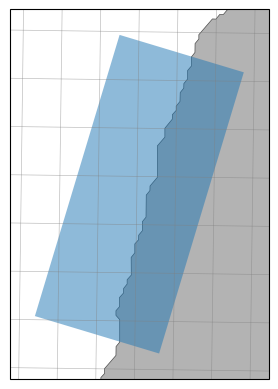

In [6]:
# Coastlines are defined by specifying the GSHHS resolution

ax = grid.plot(scale="f")

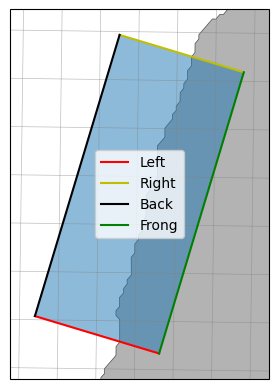

In [10]:
# Overlay the different boundaries

ax = grid.plot(scale="f")
ax.plot(grid.left[0], grid.left[1], "r", transform=grid.transform, label="Left")
ax.plot(grid.right[0], grid.right[1], "y", transform=grid.transform, label="Right")
ax.plot(grid.back[0], grid.back[1], "k", transform=grid.transform, label="Back")
ax.plot(grid.front[0], grid.front[1], "g", transform=grid.transform, label="Frong")

ax.legend()

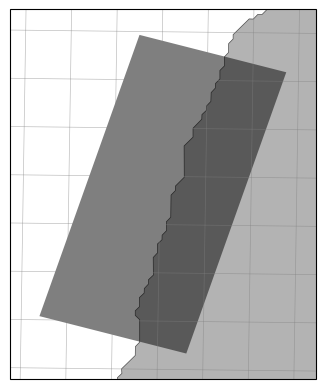

In [11]:
# Different projections can be used

ax = grid.plot(
    scale="f",
    projection=ccrs.PlateCarree(),
    grid_kwargs=dict(alpha=0.5, facecolor="black", zorder=2),
)

Different land mask can be used by not specifying the GSHHS scale parameter. In the
example below we overlay the grid with the Google OSM polygon read from the [Oceanum.io](https://oceanum.io/) Datamesh

In [12]:
from oceanum.datamesh import Connector

# Replace your token here
datamesh = Connector(token=None)

# Query the OSM data around the grid
query = {
    "datasource": "osm-land-polygons",
    "geofilter": {
        "type": "bbox",
        "geom": [grid.ori.x-0.1, grid.ori.y-0.1, grid.ori.x+0.1, grid.ori.y+0.1]}
}
land = datamesh.query(query).dissolve()
land

,geom,x,y
0,"POLYGON ((115.67373 -33.0005, 115.67331 -32.99...",115,-33


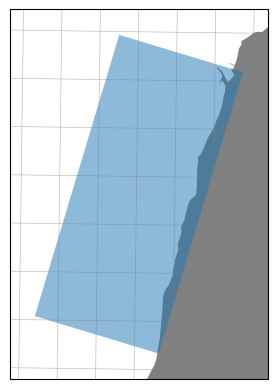

In [10]:
# Plot the grid without the GSHHS layer
ax = grid.plot(projection=ccrs.PlateCarree())

# Add the OSM layer
ax = land.plot(ax=ax, transform=ccrs.PlateCarree(), color="gray")

Save the grid as a kml file to view on Google Earth

In [16]:
import geopandas

gdf = geopandas.GeoSeries(grid.boundary(), crs=grid.crs)
gdf.to_file("grid_xbeach.kml", driver="KML")

INFO:pyogrio._io:Created 1 records
